In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
from numpy.typing import ArrayLike
from typing import List, Union

import itertools

import numpy as np
from sklearn import datasets
from nn import nn, preprocess, io
import matplotlib.pyplot as plt

# Step 2: generate your autoencoder

#### Read in toy digits dataset

In [3]:
digits = datasets.load_digits()
x = digits['data']

#### Generate a train/test split

In [4]:
def train_test_split(
    x: Union[List[Union[float, int]], ArrayLike],
    y: [Union[List[Union[float, int]], ArrayLike]],
    test_ratio: float = 0.3,
):
    xypairs = list(zip(x, y))

    test_sz = int(len(x) * test_ratio)
    all_indices = np.arange(len(x))

    test_indices = np.random.choice(all_indices, size=test_sz, replace=False)
    train_indices = [ind for ind in all_indices if ind not in test_indices]

    x_test, y_test, x_train, y_train = [], [], [], []

    for ind in test_indices:
        x_test.append(xypairs[ind][0])
        y_test.append(xypairs[ind][1])
    for ind in train_indices:
        x_train.append(xypairs[ind][0])
        y_train.append(xypairs[ind][1])

    return x_train, y_train, x_test, y_test

In [21]:
x_train, y_train, x_test, y_test = train_test_split(x, x)
data = train_test_split(x, x)

arch = [{'input_dim': 64, 'output_dim': 16}, {'input_dim': 16, 'output_dim': 64}]
seed = 0

## Hyperparameter tuning
* I chose to implement a grid search over some possible hyperparameter settings for this task
* I trained a model for each hyperparameter combination and then chose the one with the best validation loss

* We want to use mean squared error loss because for the autoencoder task we want to learn a representation that can be used to reconstruct the original data pixel intensities 

In [14]:
lr_grid = [1e-1, 1e-2, 1e-3, 1e-4]
bs_grid = [50, 100, 200, 300, 400, 800]
epochs_grid = [5, 10, 20, 30, 40, 50, 100]

In [34]:
test_losses_grid = {}
models_grid = {}

for grid_combination in itertools.product(lr_grid, bs_grid, epochs_grid):
    lr, bs, epoch = grid_combination
    network = nn.NeuralNetwork(arch, lr, seed, bs, epochs, 'mse', activations=['sigmoid', None])
    train_losses, test_losses = network.fit(x_train, y_train, x_test, y_test)
    last_test_loss = test_losses[-1]
    
    # code does this but wanted to make it clear to reader losses are stored as attr
    network.train_losses = train_losses
    network.test_losses = test_losses
    
    grid_key = (lr, bs, epoch)
    test_losses_grid[grid_key] = last_test_loss
    models_grid[grid_key] = network

In [35]:
best_grid_param = min(test_losses_grid, key=test_losses_grid.get)
best_loss_val = test_losses_grid[best_grid_param]
best_network = models_grid[best_grid_param]

#### Plot training and testing loss per epoch

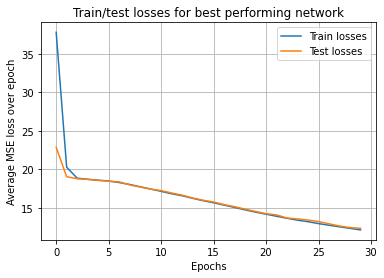

In [49]:
plt.plot(best_network.train_losses, label='Train losses')
plt.plot(best_network.test_losses, label='Test losses')
_ = plt.title('Train/test losses for best performing network')
_ = plt.grid()
_ = plt.legend()
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Average MSE loss over epoch')

#### Quantify your average reconstruction error over the dataset

In [48]:
loss_across_dataset = best_network._eval_loader(x, x, train=False)
loss_across_dataset = np.round(loss_across_dataset, 3)
print(f'Average loss across dataset: {loss_across_dataset}')

Average loss across dataset: 12.249


# Step 3: generate your transcription factor classifier

#### Read in data

In [52]:
positive_examples = io.read_text_file('data/rap1-lieb-positives.txt')
negative_examples = io.read_fasta_file('data/yeast-upstream-1k-negative.fa')

#### Resample to have equal class balance

In [59]:
all_examples = [positive_examples + negative_examples, [0] * len(positive_examples) + [1] * len(negative_examples)]
resampled_seqs, resampled_labels = preprocess.sample_seqs(*all_examples)
resampled_seqs_ohe = preprocess.one_hot_encode_seqs(resampled_seqs)

#### Generate train/test split

In [63]:
len(negative_examples[0])

1000

In [64]:
# not sure if supposed to be using this data; negative examples are much larger sequences than the positive
# are we supposed to use the rap1-lieb-test?

In [ ]:
x_train, y_train, xe_test, y_test = train_test_split(resampled_seqs_ohe, resampled_labels)
arch = [{'input_dim': 4000, 'output_dim': 16}, {'input_dim': 16, 'output_dim': 64}]
seed = 0